# Data Mining Project - WNBA Playoffs Prediction - G24

## Business Understanding

#### Our data
Basketball tournaments are usually split in two parts. First, all teams play each other aiming to achieve the greatest number of wins possible. Then, at the end of the first part of the season, a pre determined number of teams which were able to win the most games are qualified to the playoff season, where they play series of knock-out matches for the trophy.

For the 10 years, data from players, teams, coaches, games and several other metrics were gathered and arranged on this dataset. The goal is to use this data to predict which teams will qualify for the playoffs in the next season.



#### Competition Format
The 12 teams in the WNBA are split into an Eastern Conference and a Western Conference. WNBA fixtures begin with preseason games in May before each team plays 20 home games and 20 road games during the regular season.

The aim for every team is to qualify for the Playoffs, which begin in September each year.

The WNBA teams with the eight best regular season records regardless of standing qualify for the Playoffs. Higher seeds matchup with lower seeds, so the top seed faces the eight seed, the second seed faces the seven seed and so on.

When it comes to betting on the Playoffs, the first round are best-of-three series. The semifinals and final are both best-of-five, meaning WNBA teams need to record three wins to claim victory in the series.

## Database Connection

We used a free service to host our database. The Database is in PostgreSQL.

In [2]:
import json
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [3]:
# DB Credentials

with open("config.json") as config_file:
    config = json.load(config_file)

host = config["db_host"]
user = config["db_user"]
password = config["db_password"]
database = config["db_database"]
schema = config["db_schema"]

In [4]:
connection = psycopg2.connect(
    host=host,
    user=user,
    password=password,
    database=database
)

cursor = connection.cursor()

def execute(query):
    cursor.execute(query)
    connection.commit()
    return cursor.fetchall()

def fetch(query):
    cursor.execute(query)
    return cursor.fetchall()

SELECT = "SELECT * FROM " + schema + "." # + table_name 
INSERT = "INSERT INTO " + schema + "." # + table_name + " VALUES " + values
UPDATE = "UPDATE " + schema + "." # + table_name + " SET " + column_name + " = " + value
DELETE = "DELETE FROM " + schema + "."  # + table_name + " WHERE " + column_name + " = " + value

# Test data, year 10
TEST_DATA = "year = 10"
TRAIN_DATA = "year < 10"

 The data about the players, teams and coaches consist of following relations:

    awards_players (96 objects) - each record describes awards and prizes received by players across 10 seasons,
    coaches (163 objects) - each record describes all coaches who've managed the teams during the time period,
    players (894 objects) - each record contains details of all players,
    players_teams (1877 objects) - each record describes the performance of each player for each team they played,
    series_post (71 objects) - each record describes the series' results,
    teams (143 objects) - each record describes the performance of the teams for each season,
    teams_post (81 objects) - each record describes the results of each team at the post-season.


In [5]:
awards_players = fetch(SELECT + "awards_players") # awards and prizes received by players across 10 seasons,
coaches = fetch(SELECT + "coaches") # all coaches who've managed the teams during the time period,
players = fetch(SELECT + "players") # details of all players,
players_teams = fetch(SELECT + "players_teams") # performance of each player for each team they played,
series_post = fetch(SELECT + "series_post") # series' results,
teams = fetch(SELECT + "teams") # performance of the teams for each season,
teams_post = fetch(SELECT + "teams_post") # results of each team at the post-season.

In [6]:
#save the data in a dataframe
awards_players_df = pd.DataFrame(awards_players, columns=['playerID', 'award', 'year', 'lgID'])
coaches_df = pd.DataFrame(coaches, columns=['coachID', 'year', 'tmID', 'lgID', 'stint', 'won', 'lost', 'post_wins', 'post_losses'])
players_df = pd.DataFrame(players, columns=['bioID', 'pos', 'firstseason', 'lastseason', 'height', 'weight', 'college', 'collegeOther', 'birthDate', 'deathDate'])
players_teams_df = pd.DataFrame(players_teams, columns=['playerID', 'year', 'stint', 'tmID', 'lgID', 'GP', 'GS', 'minutes', 'points', 'oRebounds', 'dRebounds', 'rebounds', 'assists', 'steals', 'blocks', 'turnovers', 'PF', 'fgAttempted', 'fgMade', 'ftAttempted', 'ftMade', 'threeAttempted', 'threeMade', 'dq', 'PostGP', 'PostGS', 'PostMinutes', 'PostPoints', 'PostoRebounds', 'PostdRebounds', 'PostRebounds', 'PostAssists', 'PostSteals', 'PostBlocks', 'PostTurnovers', 'PostPF', 'PostfgAttempted', 'PostfgMade', 'PostftAttempted', 'PostftMade', 'PostthreeAttempted', 'PostthreeMade', 'PostDQ'])
series_post_df = pd.DataFrame(series_post, columns=['year', 'round', 'series', 'tmIDWinner', 'lgIDWinner', 'tmIDLoser', 'lgIDLoser', 'W', 'L'])
teams_df = pd.DataFrame(teams, columns=['year', 'lgID', 'tmID', 'franchID', 'confID', 'divID', 'rank', 'playoff', 'seeded', 'firstRound', 'semis', 'finals', 'name', 'o_fgm', 'o_fga', 'o_ftm', 'o_fta', 'o_3pm', 'o_3pa', 'o_oreb', 'o_dreb', 'o_reb', 'o_asts', 'o_pf', 'o_stl', 'o_to', 'o_blk', 'o_pts', 'd_fgm', 'd_fga', 'd_ftm', 'd_fta', 'd_3pm', 'd_3pa', 'd_oreb', 'd_dreb', 'd_reb', 'd_asts', 'd_pf', 'd_stl', 'd_to', 'd_blk', 'd_pts', 'tmORB', 'tmDRB', 'tmTRB', 'opptmORB', 'opptmDRB', 'opptmTRB', 'won', 'lost', 'GP', 'homeW', 'homeL', 'awayW', 'awayL', 'confW', 'confL', 'min', 'attend', 'arena'])
teams_post_df = pd.DataFrame(teams_post, columns=['year', 'tmID', 'lgID', 'W', 'L'])

#make a dictionary with all the dataframes
dfs = {'awards_players_df': awards_players_df, 'coaches_df': coaches_df, 'players_df': players_df, 'players_teams_df': players_teams_df, 'series_post_df': series_post_df, 'teams_df': teams_df, 'teams_post_df': teams_post_df}

## Data Understanding

### First approach

We started with a Exploratory Data Analysis. There are 7 different tables, with different sizes both in lines and columns

In [ ]:
#for each table, print the table name, number of rows and columns
for df in dfs:
    print(df)
    print(dfs[df].shape,'\n')

Before jumping into the data analysis, one of the first things we noticed is that all the tables have an "League ID" (lgID) attribute. As the WNBA is the only league we are covering, and there is no variability in this column, we can drop it, as well as other columns that may have always the same content

In [7]:
#Drop columns whose values are always the same
for df in dfs:
    for col in dfs[df].columns:
        if len(dfs[df][col].unique()) == 1:
            print(df, col)
            dfs[df].drop(col, inplace=True, axis=1)

awards_players_df lgID
coaches_df lgID
players_df firstseason
players_df lastseason
players_teams_df lgID
series_post_df lgIDWinner
series_post_df lgIDLoser
teams_df lgID
teams_df divID
teams_df seeded
teams_df tmORB
teams_df tmDRB
teams_df tmTRB
teams_df opptmORB
teams_df opptmDRB
teams_df opptmTRB
teams_post_df lgID


Before continuing, we also need to drop the death athletes

In [8]:
#drop rows where death date is not 0000-00-00
players_df = players_df[players_df['deathDate'] == '0000-00-00']
dfs['players_df'] = players_df

#### Describing the data

For starters, we printed the head of each table, to get a sense of the data

In [ ]:
# do a head of each table
for df in dfs:
    print(df)
    display(dfs[df].head())
    

Having an idea of what the data looks like, we now want to see a more detailed description to get more information

In [ ]:
# do a describe of each table
for df in dfs:
    print(df)
    display(dfs[df].describe(include='all'))
    

In [ ]:
  # do a info of each table
for df in dfs:
    print(df)
    print(dfs[df].info(), '\n')

With the info and describes we understand that:
- There are no Null entries (although there values that are simply an empty string), as we will also prove next.
- There are some columns with the DataType "object", most of them being strings.
- There are binary objects (like confID and playoff, in the 'teams' table, with the values "Y" or "N") that could be substituted by a binary, as well as ternary objects (like the firstRound, semis and finals in the 'teams' table, with the values "W", "L" or "") that could also be transformed.

In [ ]:
# do a isnull of each table to see if there are null values
for df in dfs:
    print(df)
    print(dfs[df].isnull().sum(), '\n')

We wanted to see what were the different values for the objects and check if there were more objects that could be transformed into binary and ternary variables, so we printed the objects unique values and their frequencies.

In [ ]:
# check the value counts for each column of type object
for df in dfs:
    print(df)
    for col in dfs[df].columns:
        if dfs[df][col].dtype == 'object':
            print(dfs[df][col].value_counts(), '\n')

- We conclude the previous identified variables are the only objects with 2 or 3 unique values (confID and playoff, in the 'teams' table, with the values "Y" or "N" and the firstRound, semis and finals in the 'teams' table, with the values "W", "L" or "").
- There are players with no position and no college assigned ("").
- There are players with no date of birth in the record (0000-00-00).

We moved on to the numerical variables, trying to find outliers using boxplots (as we have a lot of variables, we only run for the ones we thought had outliers)

In [ ]:
for df in dfs:
    #print(df)
    
    # do box plots of the numerical columns
    for col in dfs[df].columns:
        if dfs[df][col].dtype != 'object':
            if col == 'height' or col == 'weight':
                plt.figure(figsize=(10, 10))
                sns.boxplot(x=dfs[df][col])
                plt.show()
    

- Looking at the boxplots, we can understand that the height and weight variables have default 0 values and should be treated as null values.

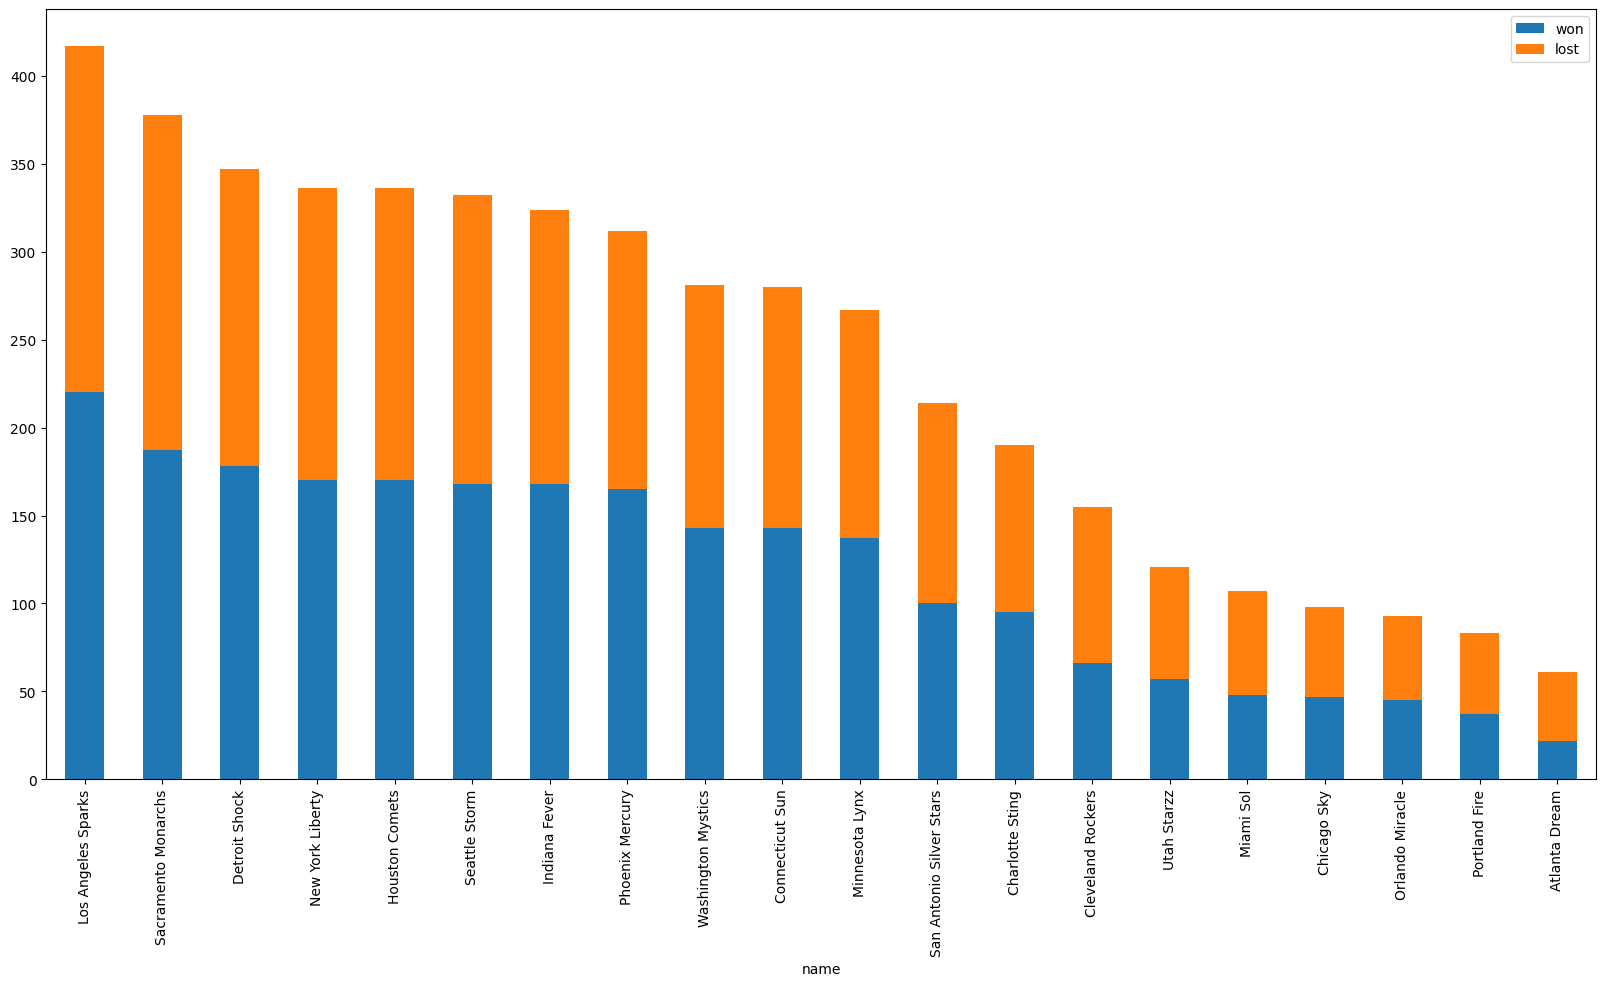

In [9]:
#wins and losses by team, sorted by number of wins: stacked bar chart
wins_by_team = teams_df.groupby('name')['won'].sum().sort_values(ascending=False)
losses_by_team = teams_df.groupby('name')['lost'].sum().sort_values(ascending=False)
wins_by_team = wins_by_team.reset_index()
losses_by_team = losses_by_team.reset_index()
wins_by_team['lost'] = losses_by_team['lost']
wins_by_team = wins_by_team.sort_values(by='won', ascending=False)
wins_by_team = wins_by_team.set_index('name')
wins_by_team.plot(kind='bar', stacked=True, figsize=(20, 10))
plt.show()

- The number of games played by each team differs (there may be teams that are no longer playing), so we can't compare the number of wins and losses directly. We need to calculate the percentage of wins and losses for each team.

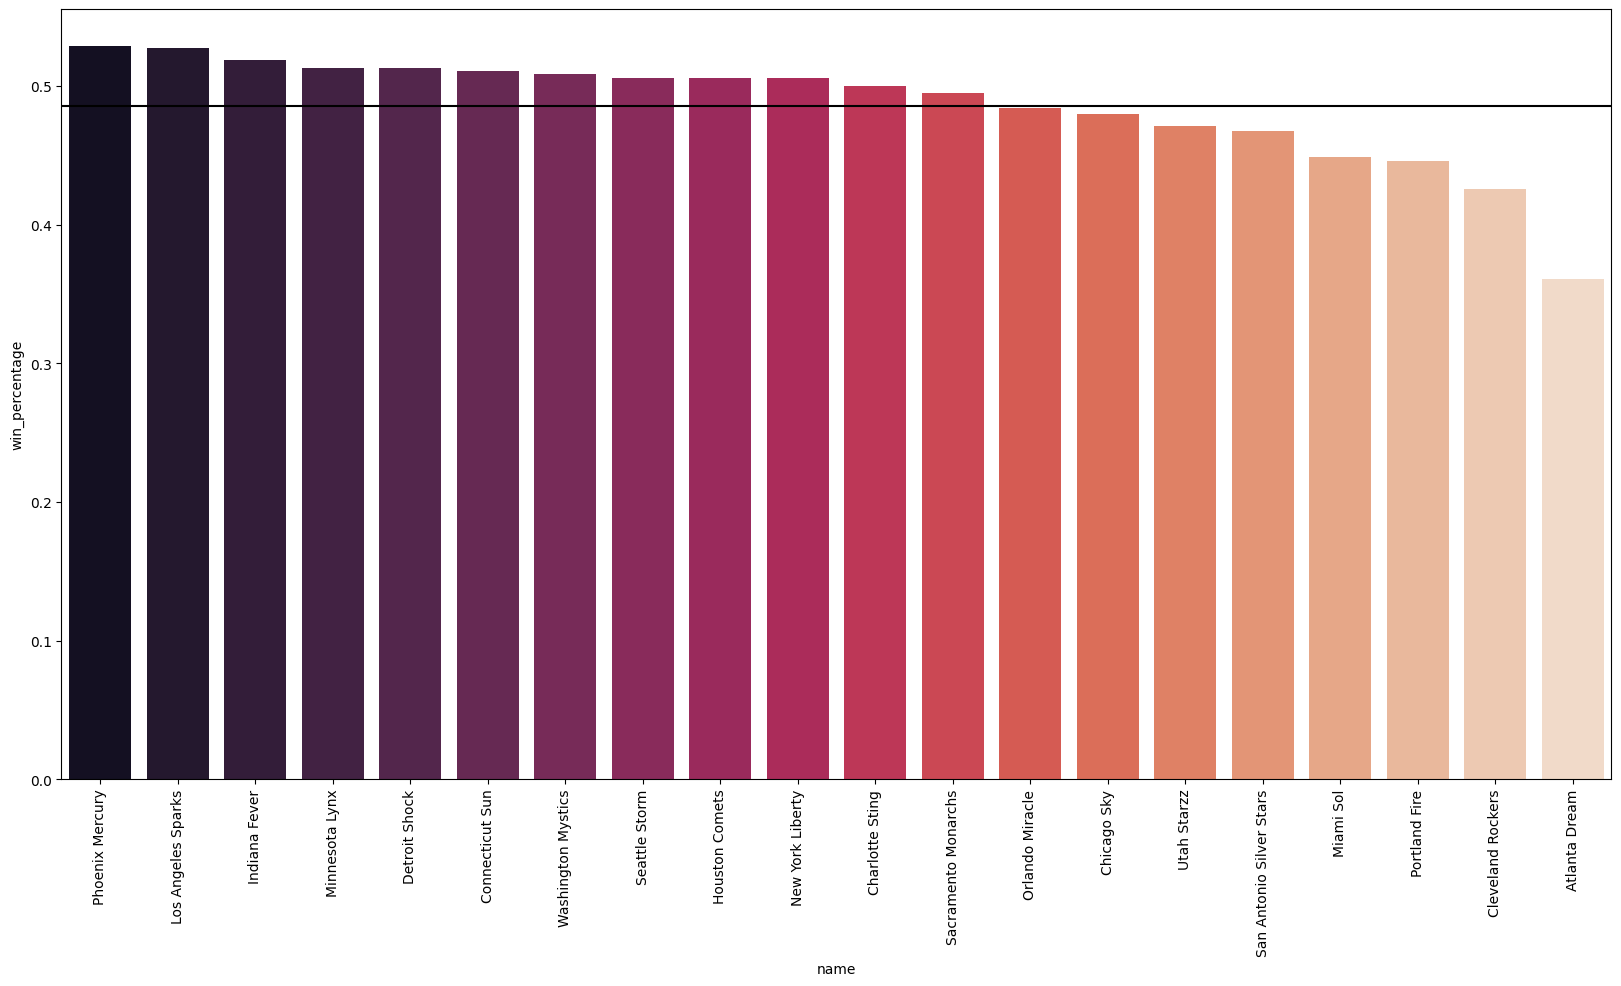

In [10]:
#win percentage by team, sorted by win percentage: bar chart with color gradient, with a horizontal line at the league average
wins_by_team['win_percentage'] = wins_by_team['won'] / (wins_by_team['won'] + wins_by_team['lost'])
wins_by_team = wins_by_team.sort_values(by='win_percentage', ascending=False)
plt.figure(figsize=(20, 10))
sns.barplot(x=wins_by_team.index, y=wins_by_team['win_percentage'], palette='rocket')
plt.axhline(wins_by_team['win_percentage'].mean(), color='black')
plt.xticks(rotation=90)
plt.show()

- In terms of win percentage, it seems like a competitive league, with more than half of the teams having a win percentage of 50% or more, taking advantage of the worst teams. There is also just one team below 40% of wins.

As we saw that there were teams it more games than the others, we want to see which teams played in which seasons, to see if there are teams that are no longer playing

In [32]:
#Enumerate the seasons a team played in the league
seasons_by_team = teams_df.groupby('name')['year']
print(seasons_by_team.unique())
print("-----------------------")
print(seasons_by_team.nunique())
#print number of seasons played
print("-----------------------")
#filter only teams that have played in the last season
teams_last_season = teams_df[teams_df['year'] == 10]
print(teams_last_season['name'].unique())


name
Atlanta Dream                                       [9, 10]
Charlotte Sting                       [1, 2, 3, 4, 5, 6, 7]
Chicago Sky                                   [7, 8, 9, 10]
Cleveland Rockers                              [1, 2, 3, 4]
Connecticut Sun                      [4, 5, 6, 7, 8, 9, 10]
Detroit Shock               [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Houston Comets                  [1, 2, 3, 4, 5, 6, 7, 8, 9]
Indiana Fever               [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Los Angeles Sparks          [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Miami Sol                                         [1, 2, 3]
Minnesota Lynx              [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
New York Liberty            [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Orlando Miracle                                   [1, 2, 3]
Phoenix Mercury             [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Portland Fire                                     [1, 2, 3]
Sacramento Monarchs         [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
San Antonio Silver Stars           

### Going deeper

There are tables with a lot of attributes (player_teams 43 and teams_df 61, for example). We will evaluate the correlations and delete the most correlated pairs of attributes.

In [ ]:
MAX_CORRELATION = 0.8

In [ ]:
def delete_most_correlated(df):

    players_teams_df_copy = df.copy()


    correlation_matrix = players_teams_df_copy.corr()

    sorted_correlations = correlation_matrix.unstack().sort_values(ascending=False)

    plt.figure(figsize=(20, 20))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
    plt.show()

    # Get the pairs of attributes with the highest correlation values
    most_correlated_pairs = sorted_correlations[sorted_correlations > MAX_CORRELATION]
    most_correlated_pairs = most_correlated_pairs[most_correlated_pairs < 1.0]


    #delete repeated pairs (e.g. (a,b) and (b,a))
    most_correlated_pairs = most_correlated_pairs[::2]
    print(most_correlated_pairs)

    #drop the attributes with the highest correlation values
    for pair in most_correlated_pairs.index:
        if pair[0] in players_teams_df_copy.columns:
            players_teams_df_copy.drop(pair[0], inplace=True, axis=1)
        if pair[1] in players_teams_df_copy.columns:
            players_teams_df_copy.drop(pair[1], inplace=True, axis=1)

    #print the attributes that were dropped
    print(players_teams_df_copy.columns)
    return players_teams_df_copy

Lets run the function for all the tables

In [ ]:
for df in dfs:
    print(df)
    #to make the df actually change, we have to assign it to the df
    #df = delete_most_correlated(dfs[df])
    delete_most_correlated(dfs[df])

In [ ]:
connection.close()